# Automatic Curve Fitting

In [22]:
import numpy as np
import sympy
import math
import pandas as pd
%matplotlib inline

## 1. Define Density Function Class
Create a class that represents a probabability density function which can be fit to data

In [57]:
class density_function():
    from sympy import lambdify
    def __init__(self,pdf_type):
        self.AIC = 0
        self.pdf_type = pdf_type
        self.beta_scale = 1
        
        # Define the probability density functions for various types of prbability distributions
        if pdf_type == "weibull":
            self.syms = (sympy.Symbol('a'),sympy.Symbol('B'))
            def pdf(x,a,B):
                return a/B**a * x**(a-1) * sympy.exp(-(x/B)**a)    
        elif pdf_type == "exponential":
            self.syms = tuple([sympy.Symbol('l')])
            def pdf(x,l):
                return l*sympy.exp(-l*x)*1  
        elif pdf_type == "normal":
            self.syms = (sympy.Symbol('m'),sympy.Symbol('s'))
            def pdf(x,m,s):
                return 1/(s*(2*math.pi)**.5)*sympy.exp(-(x-m)**2/(2*s**2))
        elif pdf_type == "lognormal":
            self.syms = (sympy.Symbol('m'),sympy.Symbol('s'))
            def pdf(x,m,s):
                return 1/(s*x*(2*math.pi)**.5)*sympy.exp(-(sympy.log(x)-m)**2/(2*s**2))
        elif pdf_type == "gamma":
            self.syms = (sympy.Symbol('a'),sympy.Symbol('B'))
            def pdf(x,a,B):
                return x**(a-1)/(B**a*sympy.gamma(a)) * sympy.exp(-x/B)
        elif pdf_type == "triangular":
            self.syms = (sympy.Symbol('a'),sympy.Symbol('c'),sympy.Symbol('b'))
            def pdf(x,a,c,b):
                if x>=a and x<=c:
                    return 2*(x-a)/((b-a)*(c-a))
                elif x>=c and x<=b:
                    return 2*(x-a)/((b-a)*(c-a))
                else:
                    return 0
        elif pdf_type == "beta":
            self.syms = (sympy.Symbol('a'),sympy.Symbol('B'))
            def pdf(x,a,B):
                if x<=0 or x>=1:
                    return 0
                else:
                    x_scaled = (x-self.offset)/self.beta_scale
                    return x_scaled**(a-1)*(1-x_scaled)**(B-1) / (sympy.gamma(a)*sympy.gamma(B)/sympy.gamma(a+B)) # sympy.beta(a,B)#
        elif pdf_type == "uniform":
            self.syms = tuple([sympy.Symbol('m')])
            def pdf(x,m):
                return m
            
        # Create class attributes for the probability density function and degrees of freedon (k)
        self.pdf = pdf
        self.k = len(self.syms)
    
    # Define function which to create and return loss functions based on given data
    def L_function_creator(self,data):
        pdf = self.pdf
        syms = self.syms
        
        # The loss function is the product of the value of each observations f(x)
        L_symbolic = 1
        for i, x_i in enumerate(data):
            L_symbolic = L_symbolic*pdf(x_i,*syms)
        
        from sympy import lambdify
        L_func =  lambdify(syms, L_symbolic)
        
        # The likelihood function used will be the inverse of the log of the likelihood function. The log of 
        # the likelihood is easier to work with and inverting it allows us to use minimization to maximize L
        def L_function(vec):
            return 1/sympy.log(L_func(*vec))
        return L_function
    
    # Function scales data points between 0 and 1. Only used to fit beta distribution
    def scale(self, data):
        scale = max(data)*(1.05)
        data_scaled = data/scale
        offset = (1-.05)*min(data_scaled)
        return data_scaled-offset, offset, scale
    
    # Function calculates Akike Information Criterion
    def calculate_AIC(self,data,params, k=-1):
        if k==-1:
            k=self.k
        L_inv = self.L_function_creator(data)
        self.likelihood = sympy.exp(1/L_inv(params))
        return -2/L_inv(params)+2*k
    
    # Calculates the maximum likelihood coefficient estimates
    def fit(self, data, verbose=1):
        # Handle scaling seperately for beta distribution
        if self.pdf_type == 'beta':
            self.k=4 # two coeffs (scale, offset) are estimated manually and so are not in self.syms 
            _, self.offset, self.beta_scale = self.scale(data) # calculate scale and offset
            print("beta scale", self.beta_scale)
            print("beta offset", self.offset)
            # redefine pdf with updated scale and offset
            def pdf(x,a,B):
                x_scaled = x/self.beta_scale-self.offset
                # Catch errors with improperly scaled data points
                if x_scaled <=0 or x_scaled>=1:
                    print('ERROR! Scaled point outside (0,1) for Beta')
                    print('x=',x,' x_scaled= ', x_scaled, ', Scale= ',self.beta_scale,'Offset=',self.offset)
                return x_scaled**(a-1)*(1-x_scaled)**(B-1) / (sympy.gamma(a)*sympy.gamma(B)/sympy.gamma(a+B))
            self.pdf = pdf
        
        pdf = self.pdf
        syms = self.syms
        
        from scipy.optimize import minimize 
        from scipy.optimize import LinearConstraint, Bounds

        k=self.k
        
        # Create loss function
        L_inv = self.L_function_creator(data)

        #Define bound for between 1 and 3 parameters
        b=[0,0,0]
        b[0] = Bounds(np.ones(1)*1e-100,np.ones(1)*np.inf)
        b[1] = Bounds(np.ones(2)*1e-100,np.ones(2)*np.inf)
        b[2] = Bounds(np.ones(3)*1e-100,np.ones(3)*np.inf)
        if self.pdf_type == 'uniform':
            b[0] = Bounds(np.ones(1)*1e-100,np.array([1/(max(data)-min(data))]))
            
        
        x0 = np.ones(k)/2
        if self.pdf_type == 'normal':
            x0 = np.array([np.mean(data),np.var(data)**.5])
        if self.pdf_type == 'gamma':
            x0 = np.array([6.24,1.74])
        if self.pdf_type == 'beta':
            x0 = np.array([.983, 1.35])
        if self.pdf_type == 'uniform':
            x0 = np.array([1/(max(data)-min(data))])
            print("uniform A:", min(data))
            print("uniform B:", max(data))

        # minimize loss function with respect to parameters and s.t. bounds
        sol = minimize(L_inv, x0=x0, bounds=b[len(self.syms)-1], options={'gtol': 1e-200})#k-1
        self.sol = dict(zip(syms,sol.x))
        self.AIC = self.calculate_AIC(data,sol.x)
        self.message = sol.message
        
        # Plot distribution / print output
        if verbose >=1:
            self.plot(pdf, sol.x, data, bins=0)
            if verbose>=2:
                print(f'Distribution: {self.pdf_type}')
                print(f'AIC: {self.AIC}')
                print('Solution Parameters:')
                print(self.sol)
                print()
    
    # Define function to control plotting of histogram and pdf
    def plot(self, pdf, sol, data, bins=0):
        from matplotlib import pyplot as plt
        plt.ion()
            
        M = max(data)
        m = min(data)
        # Create x and y point values according to pdf
        x_theoretical = np.arange(m,M,(M-m)/100)
        y_theoretical = [pdf(x, *sol) for x in x_theoretical]
        
        # Create list of potential values to try for number of bins
        try_bins = list(range(3,int(len(data)/2)))
        MSE_list=[]
        
        # Try different values of bins
        for bins in try_bins:
            #hist = plt.hist(data, bins)
            hist = np.histogram(data, bins)
            heights = hist[0]
            bin_xs = hist[1]
            scale = np.mean(heights) / np.mean(y_theoretical)
            y_theoretical_scaled = [y*scale for y in y_theoretical]
            
            corresponding_bins = np.digitize(x_theoretical,bin_xs)-1
            y_hist = [heights[corresponding_bin] for corresponding_bin in corresponding_bins]
            MSE = np.mean(np.square(np.array(y_hist)-np.array(y_theoretical_scaled)))
            
            MSE_list.append(MSE)
        
        self.MSE = min(MSE_list)
        bins = try_bins[np.argmin(MSE_list)]   
        #M = max(data)
        #m = min(data)
        #x_theoretical = np.arange(m,M,(M-m)/100)
        #y_theoretical = [pdf(x, *sol) for x in x_theoretical]
        #scale = np.mean(heights) / np.mean(y_theoretical)
        #y_theoretical_scaled = [y*scale for y in y_theoretical]
        
        heights = plt.hist(data, bins,edgecolor='black', linewidth=1.2)[0]
        scale = np.mean(heights) / np.mean(y_theoretical)
        y_theoretical_scaled = [y*scale for y in y_theoretical]
                        
        plt.plot(x_theoretical, y_theoretical_scaled,'.r')
        plt.ylim((0,max(heights)))
        plt.title(self.pdf_type)
        plt.show()

## 2. Define Function to Fit and Compare Each Distribution

In [54]:
def fit_all(data, distribution_list=["weibull","exponential","lognormal","normal","gamma","beta","uniform"]):
    column_list = ['Distribution','DOF','Likelihood','AIC','MSE','Parameters']
    
    #zero_data = np.zeros(shape=(len(distribution_list),len(column_list)))
    #results_df = pd.DataFrame(zero_data, columns=column_list, index=distribution_list)
    
    results_df = pd.DataFrame(columns=column_list, index=distribution_list)
    #results_df.Distribution =results_df.Distribution.astype(str)
    #results_df.Parameters =results_df.Parameters.astype(str)
    
    for distribution_type in distribution_list:
        pdf_i = density_function(distribution_type)
        pdf_i.fit(data)
        results_df.loc[distribution_type]['Distribution'] = pdf_i.pdf_type
        results_df.loc[distribution_type]['DOF'] = pdf_i.k
        results_df.loc[distribution_type]['Likelihood'] = pdf_i.likelihood
        results_df.loc[distribution_type]['AIC'] = pdf_i.AIC
        results_df.loc[distribution_type]['MSE'] = pdf_i.MSE
        results_df.loc[distribution_type]['Parameters'] = repr(pdf_i.sol)
    return results_df

## 3a. Green Light Distribution Analysis

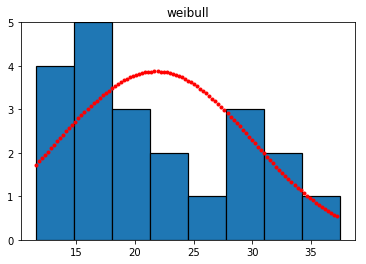

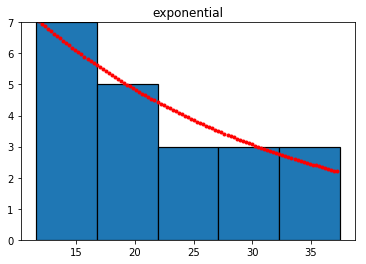

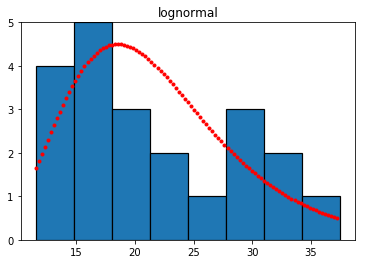

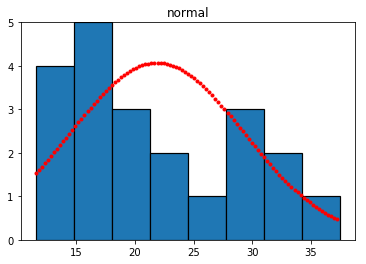

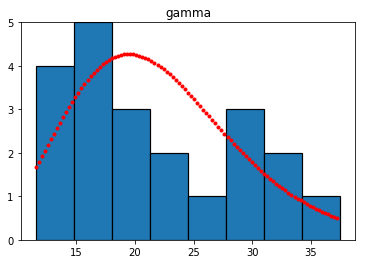

beta scale 39.354
beta offset 0.2788153681963714


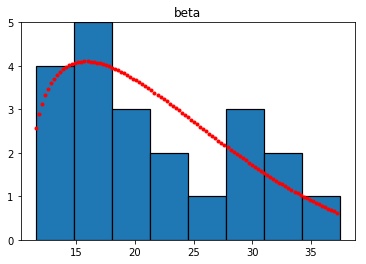

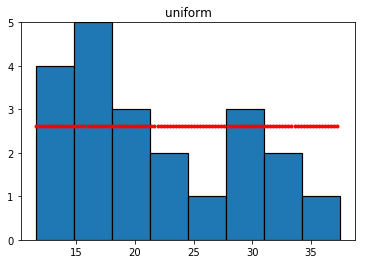

,Distribution,DOF,Likelihood,AIC,MSE,Parameters
weibull,weibull,2,9.32818614390766e-32,146.899364782014,2.14283108999963,"{a: 3.215640595688718, B: 24.475506033671447}"
exponential,exponential,1,5.52075647168757e-38,173.579437281803,0.413782131822209,{l: 0.045719831400978836}
lognormal,lognormal,2,2.84356932226157e-31,144.670155632291,1.65896206467358,"{m: 3.02944943866888, s: 0.3331712030586328}"
normal,normal,2,6.86925061723447e-32,147.511335911971,2.44480866604187,"{m: 21.87238095238095, s: 7.3742782728448395}"
gamma,gamma,2,2.22569776105964e-31,145.160134831767,1.84194212411730,"{a: 9.128055682094933, B: 2.3961688270576262}"
beta,beta,4,4498.28559553233,-8.82290324879393,0.921589510068009,"{a: 1.3606531107021622, B: 3.57400254614671}"
uniform,uniform,1,2.04242984440857e-30,138.726825181124,1.74562,{m: 0.038565368299267266}


In [55]:
import warnings
warnings.simplefilter('ignore')#"default")#'ignore')#

file_path = r'C:\Users\ryanv\Downloads\Calculations - Data.csv'
data = pd.read_csv(file_path)['Time (All Green Lights) (min)']
results_df_green = fit_all(data)
results_df_green

## 3b. Red Light Distribution Analysis

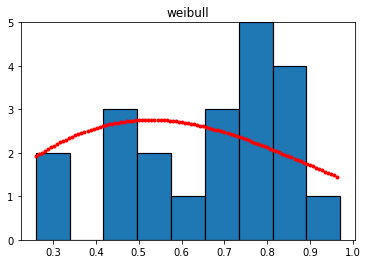

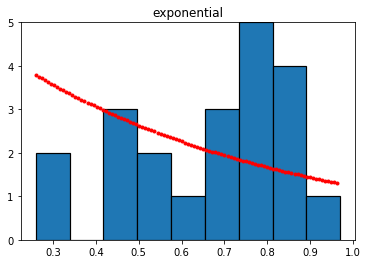

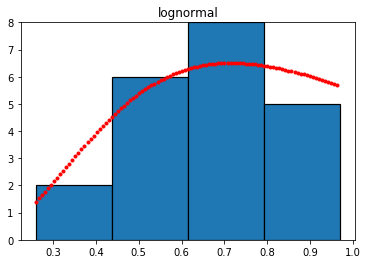

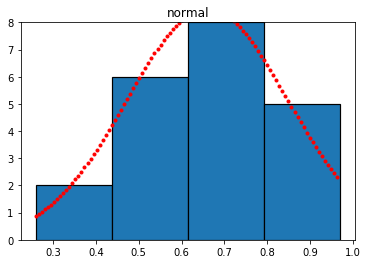

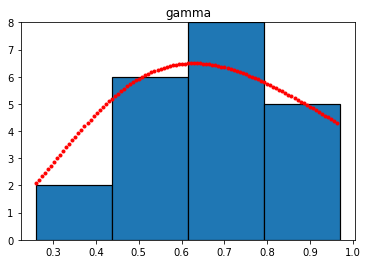

beta scale 1.0185
beta offset 0.24251350024545903


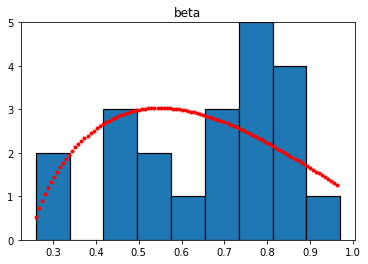

uniform A: 0.26
uniform B: 0.97


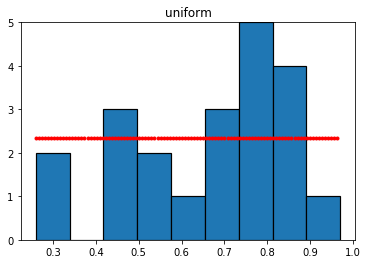

,Distribution,DOF,Likelihood,AIC,MSE,Parameters
weibull,weibull,2,0.997142072710130,4.00572403792345,2.46643184714952,"{a: 2.0753447379386385, B: 0.7241564771809321}"
exponential,exponential,1,4.74215590630513e-6,26.5180373862169,3.55124273427116,{l: 1.516245419957983}
lognormal,lognormal,2,0.000206659933873611,20.9688718943097,1.48213168429499,"{m: 1e-100, s: 0.5782399281081684}"
normal,normal,2,206.443880148353,-6.66005721725945,1.32318116275622,"{m: 0.6595238095235492, s: 0.18773020637417964}"
gamma,gamma,2,0.999999889999211,4.00000022000159,1.84145220698201,"{a: 4.867389936549527, B: 0.16227145750665242}"
beta,beta,4,83.2802587584688,-0.844423062784101,2.50160012914821,"{a: 1.7429811925885323, B: 2.7555781200244835}"
uniform,uniform,1,1329.15208506699,-12.3845929757646,2.20111,{m: 1.4084507042253522}


In [58]:
data = pd.read_csv(file_path)['Time (Single Red Light) (min)']
results_df_red = fit_all(data)
results_df_red

### Improvements Needed
 - Automatic bin selection slow and selects bin counts that leave many empty bins when given large number of points. Change value of try_bins to have non-linear upper and lower bounds (as a function of number of data points) and try only fraction of possible bins for large sample sizes (every third, etc.)
 - Scaling function for beta distribution not theoretically sound. Distribution not robust to changes in scaling procedure
 - Poor starting values can prevent some optimizations from converging. Use coefficient estimates from method of moments as initial values?
 - Uniform distribution endpoints are determined manually (this may actually give better estimates than MLE optimization)
 - Print fitted equation in clean (latex?) format